In [1]:
import pandas as pd
import numpy as np
import folium
from scipy.stats import ttest_ind, mannwhitneyu, skew
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.signal import butter, filtfilt,firwin
import matplotlib.ticker as mticker
from scipy.stats import linregress
from scipy import signal
import seaborn as sns
# matplotlib에 한글 폰트 설정
rcParams["font.family"] = "Malgun Gothic"  
rcParams["axes.unicode_minus"] = False   

In [2]:
df = pd.read_csv("에어코리아보간전.csv", parse_dates=["일시"], encoding='utf-8')
df = df.sort_values(["지점명","일시"]).reset_index(drop=True)
df.head()

,지점,지점명,망,위도,경도,일시,일 미세먼지 농도(㎍/㎥),phase,Amplitude
0,632132,강원 강릉시 옥천동,도시대기,37.76003,128.90297,2002-01-01,37.130435,7.0,1.585350
1,632132,강원 강릉시 옥천동,도시대기,37.76003,128.90297,2002-01-02,37.250000,7.0,1.402310
2,632132,강원 강릉시 옥천동,도시대기,37.76003,128.90297,2002-01-03,38.416667,7.0,1.296010
3,632132,강원 강릉시 옥천동,도시대기,37.76003,128.90297,2002-01-04,37.583333,8.0,1.009710
4,632132,강원 강릉시 옥천동,도시대기,37.76003,128.90297,2002-01-05,NaN,8.0,0.649468


In [3]:
START = pd.Timestamp("2003-01-01")
END   = pd.Timestamp("2024-12-31")

df_cut = df[(df["일시"] >= START) & (df["일시"] <= END)].copy()

# 지점별 min–max 계산
span = (
    df_cut.groupby("지점")["일시"]
          .agg(시작일="min", 종료일="max")
          .reset_index()
)
# 관측 기간 계산
span["관측일수"] = (span["종료일"] - span["시작일"]).dt.days + 1
span["관측연수"] = span["관측일수"] / 365.25

mean_years = span["관측연수"].mean()
print(" 전체 지점 평균 관측기간(년):", round(mean_years, 2))

 전체 지점 평균 관측기간(년): 21.0


In [4]:
df = df[(df["일시"] >= START) & (df["일시"] <= END+pd.Timedelta(days=30))]

In [5]:
df.isna().sum()

지점                    0
지점명                   0
망                     0
위도                    0
경도                    0
일시                    0
일 미세먼지 농도(㎍/㎥)    73408
phase                 0
Amplitude             0
dtype: int64

In [6]:
# DOY(Day of year) 계산 및 윤년 보정
df["doy"] = df["일시"].dt.dayofyear
df.loc[df["doy"] == 366, "doy"] = 365  # 윤년 → 365일로 통합

In [7]:
# 'year' 열이 없다면 추가
if 'year' not in df.columns:
    df['year'] = df['일시'].dt.year

# 지점별 총 관측 연도 계산
station_total_years = df.groupby('지점')['year'].nunique()

# 지점별 임계값(threshold) 계산 (예: 60%)
station_thresholds = (station_total_years * 0.6).apply(int)
station_thresholds = station_thresholds.rename('threshold_count').reset_index()

In [8]:
# 지점별, doy별 평균 및 유효 데이터 개수 계산 + Climatology 계산 (순환 방식 적용)
clim_stats_df = (
    df.groupby(["지점", "doy"])["일 미세먼지 농도(㎍/㎥)"]
    .agg(["mean", "count"])
    .reset_index()
)

In [9]:
clim_stats_df

,지점,doy,mean,count
0,111121,1,54.842029,23
1,111121,2,51.619565,23
2,111121,3,53.714162,23
3,111121,4,53.554820,23
4,111121,5,51.808564,23
...,...,...,...,...
83215,831154,361,57.006556,21
83216,831154,362,55.993974,22
83217,831154,363,74.420873,22
83218,831154,364,76.277964,22


In [10]:
# clim_stats_df에 지점별 임계값(threshold_count) 열을 추가
clim_stats_with_threshold = pd.merge(
    clim_stats_df, 
    station_thresholds, 
    on='지점', 
    how='left'
)

# 'count'가 'threshold_count'보다 낮은 행의 'mean' 값을 NaN으로 변경
clim_stats_with_threshold.loc[
    clim_stats_with_threshold['count'] < clim_stats_with_threshold['threshold_count'], 
    'mean'
] = pd.NA

# NaN 값이 된 행들을 확인 
invalid_clim_count = clim_stats_with_threshold['mean'].isna().sum()
if invalid_clim_count > 0:
    print(f" {invalid_clim_count}개의 신뢰할 수 없는 기후값이 NaN으로 처리되었습니다.")

# 다음 단계(smoothing)를 위해 'clim_raw'로 컬럼명 변경
clim_raw_df = clim_stats_with_threshold.rename(columns={"mean": "clim_raw"})

In [11]:
df.dropna(subset=["일 미세먼지 농도(㎍/㎥)"], inplace=True)

In [12]:
# 이동평균(31일) smoothing 적용 — 순환형 처리
stations = clim_raw_df["지점"].unique()
clim_smoothed_list = []
window_size = 31
padding_size = (window_size - 1) // 2

for station in stations:
    station_clim = clim_raw_df[clim_raw_df["지점"] == station].copy()
    if len(station_clim) < window_size:
        continue

    # 순환 padding (head/tail)
    head_padding = station_clim.tail(padding_size)
    tail_padding = station_clim.head(padding_size)
    padded_clim = pd.concat([head_padding, station_clim, tail_padding], ignore_index=True)

    # 31일 이동평균
    smoothed_values = padded_clim["clim_raw"].rolling(window_size, center=True, min_periods=1).mean()
    station_clim["clim"] = smoothed_values.iloc[padding_size:-padding_size].values
    clim_smoothed_list.append(station_clim)

# 모든 지점 결합 후 원본 데이터에 병합
clim_final = pd.concat(clim_smoothed_list, ignore_index=True)
df = pd.merge(df, clim_final[["지점", "doy", "clim"]], on=["지점", "doy"], how="left")

# 아노말리 계산
df["anom"] = df["일 미세먼지 농도(㎍/㎥)"] - df["clim"]
df.dropna(subset=["anom"], inplace=True)
print(" Climatology 및 아노말리 계산 완료.")

 Climatology 및 아노말리 계산 완료.


--- 전체 지점의 연도별 평균 아노말리---
    year       anom
0   2003  11.504969
1   2004  11.989696
2   2005  10.328211
3   2006  12.041703
4   2007  11.564594
5   2008   7.658777
6   2009   6.701826
7   2010   4.852844
8   2011   3.643719
9   2012  -1.732414
10  2013   2.329669
11  2014   2.335289
12  2015   1.069123
13  2016   0.386294
14  2017  -1.314278
15  2018  -4.592187
16  2019  -4.628189
17  2020 -12.281691
18  2021  -9.289355
19  2022 -14.904979
20  2023  -9.266856
21  2024 -16.171492
22  2025 -14.833111


C:\Users\vywjd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vywjd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


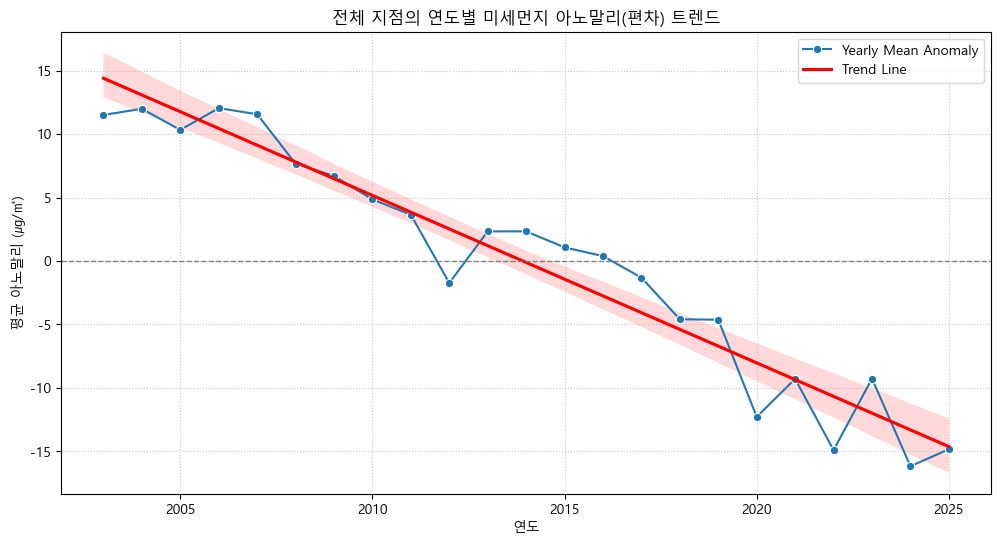

---  트렌드 통계 분석 결과 ---
기울기 (Slope): -1.3194 (㎍/㎥ per year)
P-value: 0.0000
결과: 매년 약 -1.3194 ㎍/㎥씩 '통계적으로 유의미하게 감소'하는 추세입니다.


In [13]:
if 'year' not in df.columns:
    df['year'] = df['일시'].dt.year

# --- 2. 연도별 평균 아노말리 계산 ---
# 모든 지점의 아노말리를 연도별로 평균냅니다.
yearly_anom_trend = df.groupby('year')['anom'].mean().reset_index()

print("--- 전체 지점의 연도별 평균 아노말리---")
print(yearly_anom_trend)

plt.figure(figsize=(12, 6))

sns.lineplot(data=yearly_anom_trend, x='year', y='anom', marker='o', label='Yearly Mean Anomaly')

# 장기 트렌드 선 (선형 회귀선)
# regplot이 추세선을 가장 잘 보여줍니다.
sns.regplot(data=yearly_anom_trend, x='year', y='anom', scatter=False, color='red', label='Trend Line')

# 0점 기준선 (아노말리가 0보다 높은지/낮은지)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

plt.title('전체 지점의 연도별 미세먼지 아노말리(편차) 트렌드')
plt.xlabel('연도')
plt.ylabel('평균 아노말리 (㎍/㎥)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# --- 트렌드 통계 분석 (Linear Regression) ---
x = yearly_anom_trend['year']
y = yearly_anom_trend['anom']

# 기울기(slope), p-value 등을 계산
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"---  트렌드 통계 분석 결과 ---")
print(f"기울기 (Slope): {slope:.4f} (㎍/㎥ per year)")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    if slope < 0:
        print(f"결과: 매년 약 {slope:.4f} ㎍/㎥씩 '통계적으로 유의미하게 감소'하는 추세입니다.")
    else:
        print(f"결과: 매년 약 {slope:.4f} ㎍/㎥씩 '통계적으로 유의미하게 증가'하는 추세입니다.")
else:
    print("결과: 통계적으로 유의미한 장기 추세는 발견되지 않았습니다. (p-value > 0.05)")

# 경고가 떠서 무한대값이 있나 찾아봤지만 그저 경고였다 :)
C:\Users\vywjd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vywjd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', Tru 
e):

In [14]:
# scipy.signal.detrend 함수를 사용 (가장 간단한 선형 추세 제거)
# 각 '지점'별로 그룹화하여 추세 제거 적용
# transform을 사용하면 결과가 원래 df와 같은 순서/길이로 반환됨
df['anom_detrended'] = df.groupby('지점')['anom'].transform(
    lambda x: signal.detrend(x.fillna(0)) # NaN은 임시로 0으로 채우고 detrend 적용
)

In [15]:
df.isna().sum()

지점                0
지점명               0
망                 0
위도                0
경도                0
일시                0
일 미세먼지 농도(㎍/㎥)    0
phase             0
Amplitude         0
doy               0
year              0
clim              0
anom              0
anom_detrended    0
dtype: int64

---  전체 지점의 연도별 'anom_detrended' 평균 ---
    year  anom_detrended
0   2003       -2.624440
1   2004       -0.920287
2   2005       -1.321432
3   2006        1.487042
4   2007        2.185836
5   2008       -0.459859
6   2009       -0.111390
7   2010       -0.621653
8   2011       -0.464708
9   2012       -4.449787
10  2013        0.991345
11  2014        2.363298
12  2015        2.421008
13  2016        3.037278
14  2017        2.723449
15  2018        0.781306
16  2019        2.114791
17  2020       -4.114095
18  2021        0.107609
19  2022       -4.144718
20  2023        2.862529
21  2024       -2.689350
22  2025       -0.690648


C:\Users\vywjd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vywjd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


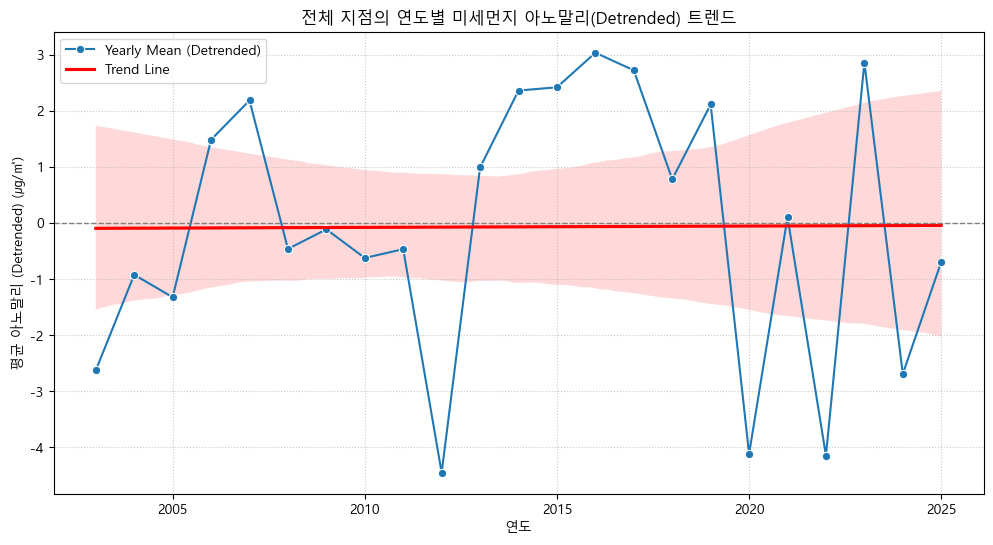

In [17]:
# 모든 지점의 'anom_detrended'를 연도별로 평균냅니다.
yearly_detrended_trend = df.groupby('year')['anom_detrended'].mean().reset_index()

yearly_detrended_trend.dropna(subset=['anom_detrended'], inplace=True)


print("---  전체 지점의 연도별 'anom_detrended' 평균 ---")
print(yearly_detrended_trend)

# --- 3. 트렌드 시각화 (Seaborn) ---
plt.figure(figsize=(12, 6))

# 'anom_detrended'의 연도별 평균 선 그래프
sns.lineplot(data=yearly_detrended_trend, x='year', y='anom_detrended', marker='o', label='Yearly Mean (Detrended)')

# 장기 트렌드 선 (선형 회귀선)
# 'anom_detrended'의 트렌드(가급적 0에 가까워야 함)를 확인합니다.
sns.regplot(data=yearly_detrended_trend, x='year', y='anom_detrended', scatter=False, color='red', label='Trend Line')

# 0점 기준선
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

plt.title('전체 지점의 연도별 미세먼지 아노말리(Detrended) 트렌드')
plt.xlabel('연도')
# [수정] Y축 레이블
plt.ylabel('평균 아노말리 (Detrended) (㎍/㎥)') 
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [ ]:
output_filename = "에어코리아장기추세제거.csv"
df.to_csv(output_filename, index=False, encoding="utf-8-sig")